This Appendix contains variations of model architectures that were trained during the process of creating a sentiment analysis for the TensorFlow IMDB data set

In [1]:
#########################
### Necessary imports ###
########################

# Reading and cleaning the data 
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import text_to_word_sequence 
from gensim.parsing.preprocessing import remove_stopword_tokens, remove_stopwords
from nltk.stem import PorterStemmer
import csv

# Embedding with Word2vec
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Deep Learning Models
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import regularizers 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping

# Visualization 
import matplotlib.pyplot as plt

2022-09-09 06:11:16.891835: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-09 06:11:16.891878: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#########################
### Loading the data ###
########################

#### Splits the data set
# creates 2 tuples for which the 1st index are the reviews and the 2nd are the classes 0 or 1
train_data, test_data = tfds.load(name="imdb_reviews", split=["train", "test"], batch_size=-1, as_supervised=True)

#### Converting a tf.data.Dataset to an iterable of NumPy arrays.
# we create arrays with the reviews and the classes by splitting the tuples above. 
# each index of the tuples will be [0] a review (sentences) or [1] a class (y)
train_sentences, y_train = tfds.as_numpy(train_data) 
test_sentences, y_test = tfds.as_numpy(test_data) 

Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


2022-09-09 06:11:19.961165: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-09 06:11:19.961201: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-09 06:11:19.961220: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-H79J9CT): /proc/driver/nvidia/version does not exist
2022-09-09 06:11:19.962034: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


In [3]:
#########################
### Cleaning the data ###
#########################

#### iterates through all the elements of sentences converting bytes to strings
# at the same time it removes stop words
X_train = [remove_stopwords(_.decode("utf-8")) for _ in train_sentences] 
X_test = [remove_stopwords(_.decode("utf-8")) for _ in test_sentences]

#### Stemming 
ps = PorterStemmer()
X_train = [ps.stem(_, to_lowercase=False) for _ in X_train]
X_test = [ps.stem(_, to_lowercase=False) for _ in X_test]

#### text_to_word_sequence() converts a text (strings) to a sequence of words (or tokens)
# it already has some parametres that clean the data as default (punctuation and sets all to lower case)

#### converting strings to lists of words. We will have a list of lists both for X_train and X_test.
# each list is one single review split into words (each word is an element of the list).
# for the main bigger list, each index will be, obviously, a list of words.
X_train = [text_to_word_sequence(_) for _ in X_train] 
X_test = [text_to_word_sequence(_) for _ in X_test]
  
X_train, y_train, X_test, y_test

([['this',
   'absolutely',
   'terrible',
   'movie',
   "don't",
   'lured',
   'christopher',
   'walken',
   'michael',
   'ironside',
   'both',
   'great',
   'actors',
   'simply',
   'worst',
   'role',
   'history',
   'even',
   'great',
   'acting',
   'redeem',
   "movie's",
   'ridiculous',
   'storyline',
   'this',
   'movie',
   'early',
   'nineties',
   'us',
   'propaganda',
   'piece',
   'the',
   'pathetic',
   'scenes',
   'columbian',
   'rebels',
   'making',
   'cases',
   'revolutions',
   'maria',
   'conchita',
   'alonso',
   'appeared',
   'phony',
   'pseudo',
   'love',
   'affair',
   'walken',
   'pathetic',
   'emotional',
   'plug',
   'movie',
   'devoid',
   'real',
   'meaning',
   'i',
   'disappointed',
   'movies',
   'like',
   'this',
   'ruining',
   "actor's",
   'like',
   'christopher',
   "walken's",
   'good',
   'name',
   'i',
   'barely',
   'sit',
   'it'],
  ['i',
   'known',
   'fall',
   'asleep',
   'films',
   'usually',
   'c

In [4]:
### training a Word2Vec model on the training sentences and storing it into a variable word2vec

word2vec = Word2Vec(sentences=X_train, vector_size=60, min_count=10, window=10)

In [5]:
# Function to convert a sentence (list of words) into a matrix representing the words in the embedding space
def embed_sentence(word2vec, sentence):
    '''.wv gets numpy vector of a word, and the function adds it to a ndarray'''
    embedded_sentence = []
    for word in sentence:
        if word in word2vec.wv:
            embedded_sentence.append(word2vec.wv[word])
        
    return np.array(embedded_sentence)

# Function that converts a list of sentences into a list of matrices
def embedding(word2vec, sentences):
    '''uses the previously defined function and adds the arrays of vectors to a list'''
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence(word2vec, sentence)
        embed.append(embedded_sentence)
        
    return embed

# Embed the training and test sentences (applies word2vec model to out X)
X_train_embed = embedding(word2vec, X_train)
X_test_embed = embedding(word2vec, X_test)


# Pad the training and test embedded sentences: 
# as not all observations have the same lenght, padding is necessary to create a tensor
X_train_pad = pad_sequences(X_train_embed, dtype='float32', padding='post', maxlen=200)
X_test_pad = pad_sequences(X_test_embed, dtype='float32', padding='post', maxlen=200)

In [6]:
### Baseline model to assure our model predictions are better than random preddictions depending on chance. 
### In this case, our baseline accuracy is the percentage of chance of finding the class that is most present in y_train,
### in a perfectly balanced dataset like this, it is 50%. Our models should performs significantly better than this. 

np.unique(y_train, return_counts=True)

(array([0, 1]), array([12500, 12500]))

# RNN models

In [7]:
# Kernel Regularization: an L2-regularizer with alpha = 0.01
reg_l2 = regularizers.L2(0.01)

In [9]:
### Simple LSTM layer without regularization or dropout (model 1)
# overfitting

def init_model1():
    model1 = Sequential()
    model1.add(layers.Masking())
    model1.add(layers.LSTM(30, activation='tanh'))
    model1.add(layers.Dense(15, activation='relu'))
    model1.add(layers.Dense(1, activation='sigmoid'))

    model1.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    return model1

model1 = init_model1()

In [10]:
es = EarlyStopping(patience=10, restore_best_weights=True)

history1 = model1.fit(X_train_pad, y_train, 
                      batch_size = 32,
                      epochs=100,
                      validation_split=0.2,
                      callbacks=[es]
                     )

2022-09-09 04:10:53.434088: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 960000000 exceeds 10% of free system memory.


Epoch 1/100
625/625 [==============================] - 149s 220ms/step - loss: 0.4550 - accuracy: 0.7866 - val_loss: 0.3663 - val_accuracy: 0.8456
Epoch 2/100
625/625 [==============================] - 111s 178ms/step - loss: 0.3529 - accuracy: 0.8471 - val_loss: 0.3480 - val_accuracy: 0.8460
Epoch 3/100
625/625 [==============================] - 119s 191ms/step - loss: 0.3196 - accuracy: 0.8658 - val_loss: 0.3191 - val_accuracy: 0.8672
Epoch 4/100
625/625 [==============================] - 124s 198ms/step - loss: 0.2951 - accuracy: 0.8798 - val_loss: 0.3037 - val_accuracy: 0.8770
Epoch 5/100
625/625 [==============================] - 130s 209ms/step - loss: 0.2787 - accuracy: 0.8848 - val_loss: 0.2934 - val_accuracy: 0.8730
Epoch 6/100
625/625 [==============================] - 103s 165ms/step - loss: 0.2660 - accuracy: 0.8918 - val_loss: 0.3158 - val_accuracy: 0.8618
Epoch 7/100
625/625 [==============================] - 102s 163ms/step - loss: 0.2542 - accuracy: 0.8971 - val_loss: 0

In [11]:
res1 = model1.evaluate(X_test_pad, y_test, verbose=0)

print(f'The accuracy evaluated on the test set is of {res1[1]*100:.3f}%')

2022-09-09 04:39:48.474083: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1200000000 exceeds 10% of free system memory.


The accuracy evaluated on the test set is of 87.028%


In [12]:
history1_dict = history1.history
history1_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

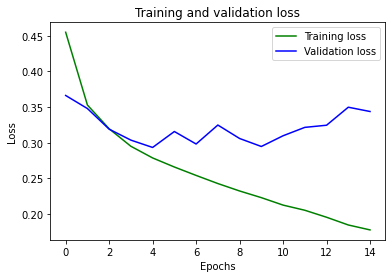

In [13]:
acc_1 = history1_dict['accuracy']
val_acc_1 = history1_dict['val_accuracy']
loss_1 = history1_dict['loss']
val_loss_1 = history1_dict['val_loss']

epochs = range(len(acc_1))

# "g" is for "solid green line"
plt.plot(epochs, loss_1, 'g', label='Training loss')

# b is for "solid blue line"
plt.plot(epochs, val_loss_1, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

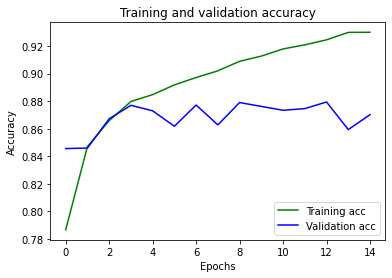

In [14]:
plt.plot(epochs, acc_1, 'g', label='Training acc')
plt.plot(epochs, val_acc_1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [15]:
### LSTM layer without regularizer (model 0)
# overfitting

def init_model_0():
    # model architecture
    model0 = Sequential()
    model0.add(layers.Masking())
    model0.add(layers.LSTM(60, activation='tanh'))
    model0.add(layers.Dense(15, activation='relu'))
    model0.add(layers.Dropout(rate=0.4))
    model0.add(layers.Dense(1, activation='sigmoid'))
    
    # model compile
    model0.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    return model0

model0 = init_model_0()

In [16]:
es = EarlyStopping(patience=10, restore_best_weights=True)

history0 = model0.fit(X_train_pad, y_train, 
                         batch_size = 32,
                         epochs=100,
                         validation_split=0.2,
                         callbacks=[es]
                        )

2022-09-09 04:45:06.627499: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 960000000 exceeds 10% of free system memory.


Epoch 1/100
625/625 [==============================] - 94s 145ms/step - loss: 0.4462 - accuracy: 0.8044 - val_loss: 0.3915 - val_accuracy: 0.8290
Epoch 2/100
625/625 [==============================] - 100s 160ms/step - loss: 0.3659 - accuracy: 0.8506 - val_loss: 0.3321 - val_accuracy: 0.8618
Epoch 3/100
625/625 [==============================] - 99s 158ms/step - loss: 0.3301 - accuracy: 0.8662 - val_loss: 0.3532 - val_accuracy: 0.8642
Epoch 4/100
625/625 [==============================] - 104s 166ms/step - loss: 0.3079 - accuracy: 0.8769 - val_loss: 0.3146 - val_accuracy: 0.8778
Epoch 5/100
625/625 [==============================] - 103s 165ms/step - loss: 0.2903 - accuracy: 0.8839 - val_loss: 0.3124 - val_accuracy: 0.8724
Epoch 6/100
625/625 [==============================] - 102s 163ms/step - loss: 0.2711 - accuracy: 0.8924 - val_loss: 0.2926 - val_accuracy: 0.8758
Epoch 7/100
625/625 [==============================] - 108s 174ms/step - loss: 0.2612 - accuracy: 0.9000 - val_loss: 0.3

In [17]:
res0 = model0.evaluate(X_test_pad, y_test, verbose=0)

print(f'The accuracy evaluated on the test set is of {res0[1]*100:.3f}%')

2022-09-09 05:13:08.572981: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1200000000 exceeds 10% of free system memory.


The accuracy evaluated on the test set is of 87.184%


In [18]:
history0_dict = history0.history
history0_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

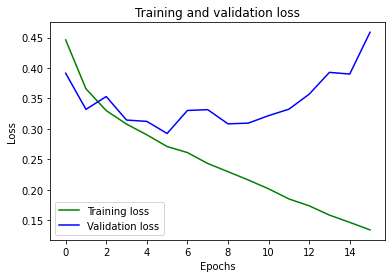

In [19]:
acc_0 = history0_dict['accuracy']
val_acc_0 = history0_dict['val_accuracy']
loss_0 = history0_dict['loss']
val_loss_0 = history0_dict['val_loss']

epochs = range(len(acc_0))

# "g" is for "solid green line"
plt.plot(epochs, loss_0, 'g', label='Training loss')

# b is for "solid blue line"
plt.plot(epochs, val_loss_0, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

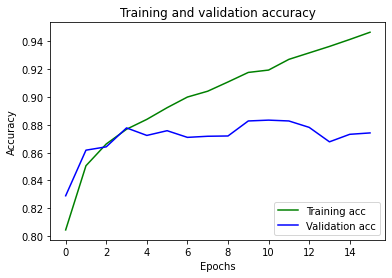

In [20]:
plt.plot(epochs, acc_0, 'g', label='Training acc')
plt.plot(epochs, val_acc_0, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [14]:
### LSTM layer with regularizer (model 2)
# good fit, but validation loss and accuracy quite messy

def init_model_2():
    # model architecture
    model2 = Sequential()
    model2.add(layers.Masking())
    model2.add(layers.LSTM(60, activation='tanh', kernel_regularizer = reg_l2))
    model2.add(layers.Dense(15, activation='relu'))
    model2.add(layers.Dropout(rate=0.4))
    model2.add(layers.Dense(1, activation='sigmoid'))
    
    # model compile
    model2.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    return model2

model2 = init_model_2()

In [15]:
es = EarlyStopping(patience=10, restore_best_weights=True)

history2 = model2.fit(X_train_pad, y_train, 
                      batch_size = 32,
                      epochs=100,
                      validation_split=0.2,
                      callbacks=[es]
                     )

Epoch 1/100
625/625 [==============================] - 93s 145ms/step - loss: 0.6446 - accuracy: 0.7992 - val_loss: 0.4732 - val_accuracy: 0.8228
Epoch 2/100
625/625 [==============================] - 95s 153ms/step - loss: 0.4598 - accuracy: 0.8364 - val_loss: 0.4316 - val_accuracy: 0.8424
Epoch 3/100
625/625 [==============================] - 94s 151ms/step - loss: 0.4308 - accuracy: 0.8425 - val_loss: 0.3700 - val_accuracy: 0.8646
Epoch 4/100
625/625 [==============================] - 88s 140ms/step - loss: 0.4038 - accuracy: 0.8533 - val_loss: 0.3825 - val_accuracy: 0.8518
Epoch 5/100
625/625 [==============================] - 96s 153ms/step - loss: 0.3895 - accuracy: 0.8547 - val_loss: 0.3593 - val_accuracy: 0.8658
Epoch 6/100
625/625 [==============================] - 96s 154ms/step - loss: 0.3772 - accuracy: 0.8598 - val_loss: 0.3682 - val_accuracy: 0.8612
Epoch 7/100
625/625 [==============================] - 103s 165ms/step - loss: 0.3718 - accuracy: 0.8627 - val_loss: 0.3650 

In [16]:
res2 = model2.evaluate(X_test_pad, y_test, verbose=1)

print(f'The accuracy evaluated on the test set is of {res2[1]*100:.3f}%')

  3/782 [..............................] - ETA: 29s - loss: 0.4231 - accuracy: 0.8229

2022-09-09 07:52:20.851855: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1200000000 exceeds 10% of free system memory.


782/782 [==============================] - 30s 39ms/step - loss: 0.3204 - accuracy: 0.8780
The accuracy evaluated on the test set is of 87.804%


In [17]:
history2_dict = history2.history
history2_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

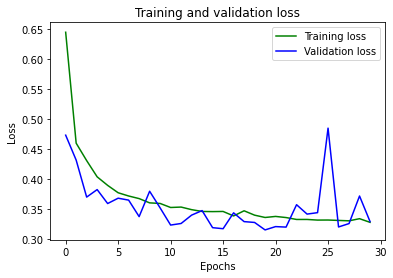

In [18]:
acc_2 = history2_dict['accuracy']
val_acc_2 = history2_dict['val_accuracy']
loss_2 = history2_dict['loss']
val_loss_2 = history2_dict['val_loss']

epochs = range(len(acc_2))

# "g" is for "solid green line"
plt.plot(epochs, loss_2, 'g', label='Training loss')

# b is for "solid blue line"
plt.plot(epochs, val_loss_2, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

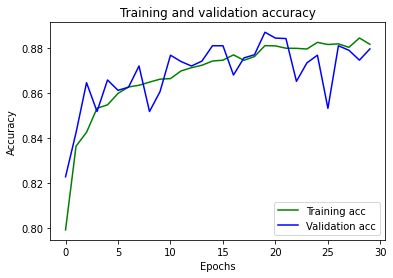

In [19]:
plt.plot(epochs, acc_2, 'g', label='Training acc')
plt.plot(epochs, val_acc_2, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [20]:
### 2 stacked LSTMs with regularizer in the 2nd layer (model 3)

def init_model_3():
    # model architecture
    model3 = Sequential()
    model3.add(layers.Masking())
    model3.add(layers.LSTM(30, activation='tanh', return_sequences=True))
    model3.add(layers.LSTM(30, activation='tanh', return_sequences=False, kernel_regularizer = reg_l2))
    model3.add(layers.Dense(15, activation='relu'))
    model3.add(layers.Dropout(rate=0.4))
    model3.add(layers.Dense(1, activation='sigmoid'))
    
    # model compile
    model3.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    return model3

model3 = init_model_3()

In [21]:
es = EarlyStopping(patience=10, restore_best_weights=True)

history3 = model3.fit(X_train_pad, y_train, 
                      batch_size = 32,
                      epochs=100,
                      validation_split=0.2,
                      callbacks=[es]
                     )

Epoch 1/100
625/625 [==============================] - 161s 250ms/step - loss: 0.5428 - accuracy: 0.8028 - val_loss: 0.3629 - val_accuracy: 0.8560
Epoch 2/100
625/625 [==============================] - 155s 248ms/step - loss: 0.3873 - accuracy: 0.8525 - val_loss: 0.3597 - val_accuracy: 0.8622
Epoch 3/100
625/625 [==============================] - 151s 241ms/step - loss: 0.3511 - accuracy: 0.8692 - val_loss: 0.3194 - val_accuracy: 0.8712
Epoch 4/100
625/625 [==============================] - 170s 272ms/step - loss: 0.3274 - accuracy: 0.8752 - val_loss: 0.3030 - val_accuracy: 0.8784
Epoch 5/100
625/625 [==============================] - 164s 262ms/step - loss: 0.3152 - accuracy: 0.8828 - val_loss: 0.3081 - val_accuracy: 0.8742
Epoch 6/100
625/625 [==============================] - 153s 245ms/step - loss: 0.3055 - accuracy: 0.8864 - val_loss: 0.3066 - val_accuracy: 0.8800
Epoch 7/100
625/625 [==============================] - 158s 253ms/step - loss: 0.2959 - accuracy: 0.8908 - val_loss: 0

In [22]:
res3 = model3.evaluate(X_test_pad, y_test, verbose=1)

print(f'The accuracy evaluated on the test set is of {res3[1]*100:.3f}%')

  2/782 [..............................] - ETA: 41s - loss: 0.3957 - accuracy: 0.8281 

2022-09-09 08:53:45.437832: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1200000000 exceeds 10% of free system memory.


782/782 [==============================] - 46s 59ms/step - loss: 0.3053 - accuracy: 0.8779
The accuracy evaluated on the test set is of 87.788%


In [23]:
history3_dict = history3.history
history3_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [24]:
acc_3 = history3_dict['accuracy']
val_acc_3 = history3_dict['val_accuracy']
loss_3 = history3_dict['loss']
val_loss_3 = history3_dict['val_loss']

epochs = range(len(acc_3))

# "g" is for "solid green line"
plt.plot(epochs, loss_3, 'g', label='Training loss')

# b is for "solid blue line"
plt.plot(epochs, val_loss_3, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

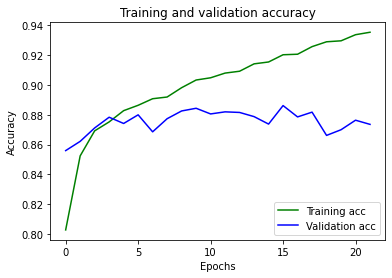

In [25]:
plt.plot(epochs, acc_3, 'g', label='Training acc')
plt.plot(epochs, val_acc_3, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [8]:
### 2 stacked LSTMs without regularizer (model 4)
# overfitting

def init_model_4():
    # model architecture
    model4 = Sequential()
    model4.add(layers.Masking())
    model4.add(layers.LSTM(30, activation='tanh', return_sequences=True))
    model4.add(layers.LSTM(30, activation='tanh', return_sequences=False))
    model4.add(layers.Dense(15, activation='relu'))
    model4.add(layers.Dropout(rate=0.4))
    model4.add(layers.Dense(1, activation='sigmoid'))
    
    # model compile
    model4.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    return model4

model4 = init_model_4()

In [9]:
es = EarlyStopping(patience=10, restore_best_weights=True)

history4 = model4.fit(X_train_pad, y_train, 
                      batch_size = 32,
                      epochs=100,
                      validation_split=0.2,
                      callbacks=[es]
                     )

Epoch 1/100
625/625 [==============================] - 162s 251ms/step - loss: 0.4362 - accuracy: 0.8113 - val_loss: 0.3585 - val_accuracy: 0.8442
Epoch 2/100
625/625 [==============================] - 163s 261ms/step - loss: 0.3586 - accuracy: 0.8561 - val_loss: 0.3182 - val_accuracy: 0.8688
Epoch 3/100
625/625 [==============================] - 168s 269ms/step - loss: 0.3256 - accuracy: 0.8683 - val_loss: 0.3069 - val_accuracy: 0.8672
Epoch 4/100
625/625 [==============================] - 174s 278ms/step - loss: 0.3093 - accuracy: 0.8769 - val_loss: 0.2895 - val_accuracy: 0.8778
Epoch 5/100
625/625 [==============================] - 179s 287ms/step - loss: 0.2913 - accuracy: 0.8849 - val_loss: 0.2874 - val_accuracy: 0.8818
Epoch 6/100
625/625 [==============================] - 166s 266ms/step - loss: 0.2797 - accuracy: 0.8910 - val_loss: 0.2932 - val_accuracy: 0.8800
Epoch 7/100
625/625 [==============================] - 163s 260ms/step - loss: 0.2699 - accuracy: 0.8929 - val_loss: 0

In [10]:
res4 = model4.evaluate(X_test_pad, y_test, verbose=1)

print(f'The accuracy evaluated on the test set is of {res4[1]*100:.3f}%')

  2/782 [..............................] - ETA: 48s - loss: 0.3380 - accuracy: 0.8594

2022-09-09 07:01:50.439942: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1200000000 exceeds 10% of free system memory.


782/782 [==============================] - 43s 55ms/step - loss: 0.2810 - accuracy: 0.8838
The accuracy evaluated on the test set is of 88.380%


In [11]:
history4_dict = history4.history
history4_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

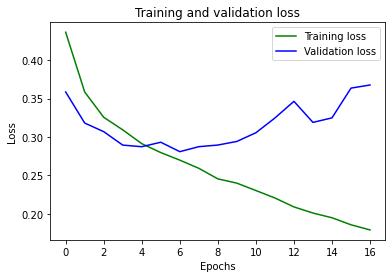

In [12]:
acc_4 = history4_dict['accuracy']
val_acc_4 = history4_dict['val_accuracy']
loss_4 = history4_dict['loss']
val_loss_4 = history4_dict['val_loss']

epochs = range(len(acc_4))

# "g" is for "solid green line"
plt.plot(epochs, loss_4, 'g', label='Training loss')

# b is for "solid blue line"
plt.plot(epochs, val_loss_4, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

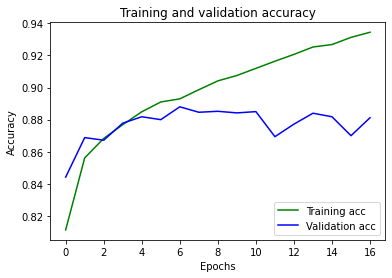

In [13]:
plt.plot(epochs, acc_4, 'g', label='Training acc')
plt.plot(epochs, val_acc_4, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [31]:
### 2 stacked LSTMs, both with regularizer (model 5)
# good fit but extremely slow training time and no accuracy improvements

def init_model_5():
    # model architecture
    model5 = Sequential()
    model5.add(layers.Masking())
    model5.add(layers.LSTM(30, activation='tanh', return_sequences=True, kernel_regularizer = reg_l2))
    model5.add(layers.LSTM(30, activation='tanh', return_sequences=False, kernel_regularizer = reg_l2))
    model5.add(layers.Dense(15, activation='relu'))
    model5.add(layers.Dropout(rate=0.4))
    model5.add(layers.Dense(1, activation='sigmoid'))
    
    # model compile
    model5.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    return model5

model5 = init_model_5()

In [32]:
es = EarlyStopping(patience=10, restore_best_weights=True)

history5 = model5.fit(X_train_pad, y_train, 
                      batch_size = 32,
                      epochs=100,
                      validation_split=0.2,
                      callbacks=[es]
                     )

Epoch 1/100
625/625 [==============================] - 233s 363ms/step - loss: 0.7174 - accuracy: 0.8099 - val_loss: 0.4601 - val_accuracy: 0.8502
Epoch 2/100
625/625 [==============================] - 157s 252ms/step - loss: 0.4529 - accuracy: 0.8473 - val_loss: 0.3919 - val_accuracy: 0.8646
Epoch 3/100
625/625 [==============================] - 157s 252ms/step - loss: 0.4145 - accuracy: 0.8532 - val_loss: 0.3667 - val_accuracy: 0.8668
Epoch 4/100
625/625 [==============================] - 152s 243ms/step - loss: 0.4041 - accuracy: 0.8569 - val_loss: 0.4031 - val_accuracy: 0.8524
Epoch 5/100
625/625 [==============================] - 156s 250ms/step - loss: 0.3959 - accuracy: 0.8592 - val_loss: 0.3573 - val_accuracy: 0.8720
Epoch 6/100
625/625 [==============================] - 149s 239ms/step - loss: 0.3871 - accuracy: 0.8618 - val_loss: 0.4431 - val_accuracy: 0.8296
Epoch 7/100
625/625 [==============================] - 152s 244ms/step - loss: 0.3848 - accuracy: 0.8640 - val_loss: 0

In [33]:
res5 = model5.evaluate(X_test_pad, y_test, verbose=1)

print(f'The accuracy evaluated on the test set is of {res5[1]*100:.3f}%')

2022-09-09 11:52:25.356948: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1200000000 exceeds 10% of free system memory.


782/782 [==============================] - 61s 78ms/step - loss: 0.3322 - accuracy: 0.8757
The accuracy evaluated on the test set is of 87.568%


In [40]:
history5_dict = history5.history
history5_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

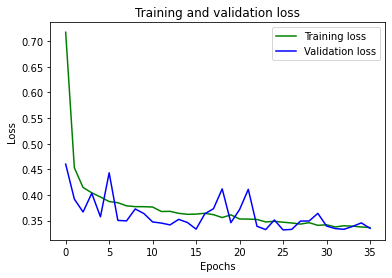

In [35]:
acc_5 = history5_dict['accuracy']
val_acc_5 = history5_dict['val_accuracy']
loss_5 = history5_dict['loss']
val_loss_5 = history5_dict['val_loss']

epochs = range(len(acc_5))

# "g" is for "solid green line"
plt.plot(epochs, loss_5, 'g', label='Training loss')

# b is for "solid blue line"
plt.plot(epochs, val_loss_5, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

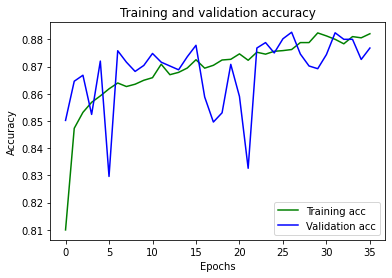

In [36]:
plt.plot(epochs, acc_5, 'g', label='Training acc')
plt.plot(epochs, val_acc_5, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

# CNN models

In [37]:
# Kernel Regularization: an L2-regularizer with alpha = 0.01
reg_l2 = regularizers.L2(0.01)

In [38]:
### One Conv1D layer with no regularization or dropout (model6)
# high accuracy as the others, but the validation loss only increases. 

def init_model_6():
    model6 = Sequential()
    model6.add(layers.Conv1D(filters=32, kernel_size=3, activation='relu'))
    model6.add(layers.Flatten())
    model6.add(layers.Dense(5,))
    model6.add(layers.Dense(1, activation='sigmoid'))

    model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model6

model6 = init_model_6()


es = EarlyStopping(patience=10, restore_best_weights=True)

history6 = model6.fit(X_train_pad, y_train, 
          epochs=20, 
          batch_size=32,
          validation_split=0.2,
          callbacks=[es]
         )

Epoch 1/20
625/625 [==============================] - 43s 68ms/step - loss: 0.4823 - accuracy: 0.7886 - val_loss: 0.3758 - val_accuracy: 0.8394
Epoch 2/20
625/625 [==============================] - 4s 7ms/step - loss: 0.3209 - accuracy: 0.8651 - val_loss: 0.3703 - val_accuracy: 0.8414
Epoch 3/20
625/625 [==============================] - 7s 11ms/step - loss: 0.2733 - accuracy: 0.8888 - val_loss: 0.4321 - val_accuracy: 0.8232
Epoch 4/20
625/625 [==============================] - 4s 7ms/step - loss: 0.2333 - accuracy: 0.9075 - val_loss: 0.4490 - val_accuracy: 0.8242
Epoch 5/20
625/625 [==============================] - 4s 7ms/step - loss: 0.2010 - accuracy: 0.9172 - val_loss: 0.4812 - val_accuracy: 0.8222
Epoch 6/20
625/625 [==============================] - 6s 10ms/step - loss: 0.1693 - accuracy: 0.9334 - val_loss: 0.5424 - val_accuracy: 0.8152
Epoch 7/20
625/625 [==============================] - 7s 12ms/step - loss: 0.1501 - accuracy: 0.9405 - val_loss: 0.6066 - val_accuracy: 0.8080
E

In [39]:
res6 = model6.evaluate(X_test_pad, y_test, verbose=1)

print(f'The accuracy evaluated on the test set is of {res6[1]*100:.3f}%')

782/782 [==============================] - 2s 2ms/step - loss: 0.3793 - accuracy: 0.8355
The accuracy evaluated on the test set is of 83.548%


In [41]:
history6_dict = history6.history
history6_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

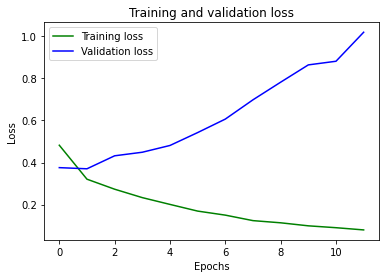

In [42]:
acc_6 = history6_dict['accuracy']
val_acc_6 = history6_dict['val_accuracy']
loss_6 = history6_dict['loss']
val_loss_6 = history6_dict['val_loss']

epochs = range(len(acc_6))

# "g" is for "solid green line"
plt.plot(epochs, loss_6, 'g', label='Training loss')

# b is for "solid blue line"
plt.plot(epochs, val_loss_6, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [43]:
plt.plot(epochs, acc_6, 'g', label='Training acc')
plt.plot(epochs, val_acc_6, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [44]:
### One Conv1D layer with L2 and dropout (model7)
# also some overfitting, the validation loss stabilizes while the training loss keeps going down

def init_model_7():
    # model architecture
    model7 = Sequential()
    model7.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer = reg_l2))
    model7.add(layers.Flatten())
    model7.add(layers.Dropout(rate=0.4))
    model7.add(layers.Dense(50, activation='relu'))
    model7.add(layers.Dense(1, activation='sigmoid'))
    
    # model compile
    
    # Instantiating the Adam optimizer starting with the initial learning rate 0.01
    initial_learning_rate = 0.01 
    
    # Implementing Exponential Decay to decrease this learning rate progressively as the network converges
    lr_schedule = ExponentialDecay(initial_learning_rate, 
                                   decay_steps = 2000, 
                                   decay_rate = 0.5)
    
    adam = Adam(learning_rate = lr_schedule)

    model7.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model7

model7= init_model_7()

In [45]:
### Fitting the embedded and padded data to the CNN model 

es = EarlyStopping(patience=10, restore_best_weights=True)

history7 = model7.fit(X_train_pad, y_train, 
                            epochs=100, 
                            batch_size=32,
                            validation_split=0.2,
                            callbacks=[es]
                           )

Epoch 1/100
625/625 [==============================] - 68s 60ms/step - loss: 0.6692 - accuracy: 0.7950 - val_loss: 0.4905 - val_accuracy: 0.8266
Epoch 2/100
625/625 [==============================] - 13s 21ms/step - loss: 0.5120 - accuracy: 0.8202 - val_loss: 0.4926 - val_accuracy: 0.8308
Epoch 3/100
625/625 [==============================] - 16s 25ms/step - loss: 0.4773 - accuracy: 0.8274 - val_loss: 0.4337 - val_accuracy: 0.8476
Epoch 4/100
625/625 [==============================] - 24s 39ms/step - loss: 0.4414 - accuracy: 0.8306 - val_loss: 0.4112 - val_accuracy: 0.8452
Epoch 5/100
625/625 [==============================] - 46s 74ms/step - loss: 0.4158 - accuracy: 0.8372 - val_loss: 0.3698 - val_accuracy: 0.8586
Epoch 6/100
625/625 [==============================] - 25s 40ms/step - loss: 0.3906 - accuracy: 0.8428 - val_loss: 0.3646 - val_accuracy: 0.8606
Epoch 7/100
625/625 [==============================] - 59s 94ms/step - loss: 0.3795 - accuracy: 0.8447 - val_loss: 0.3632 - val_ac

In [46]:
# Model evaluation
res7 = model7.evaluate(X_test_pad, y_test, verbose=1)

print(f'The accuracy evaluated on the test set is of {res7[1]*100:.3f}%')

782/782 [==============================] - 21s 26ms/step - loss: 0.3441 - accuracy: 0.8595
The accuracy evaluated on the test set is of 85.952%


In [47]:
history7_dict = history7.history
history7_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

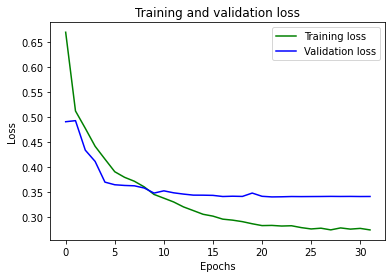

In [48]:
acc_7 = history7_dict['accuracy']
val_acc_7 = history7_dict['val_accuracy']
loss_7 = history7_dict['loss']
val_loss_7 = history7_dict['val_loss']

epochs = range(len(acc_7))

# "g" is for "solid green line"
plt.plot(epochs, loss_7, 'g', label='Training loss')

# b is for "solid blue line"
plt.plot(epochs, val_loss_7, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

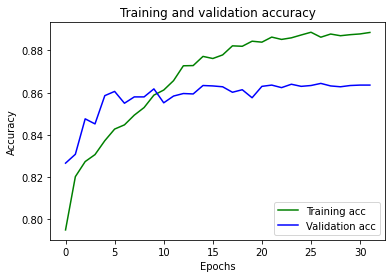

In [49]:
plt.plot(epochs, acc_7, 'g', label='Training acc')
plt.plot(epochs, val_acc_7, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()